## 목표
---
### 공통
1. **pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.**

    - 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

2. **pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.**

    - U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

3. **학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.**

    - 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

---
### 개인 
1. **CGAN, Pix2Pix의 모델 이해**

2. **epoch에따른 변화 확인**
    - epoch별 이미지를 비교하여 generator가 점점 유사한 이미지를 생성해내는 것을 확인한다

3. **파라미터 변경하여 논문에 나온 모델과 비교**

##  STEP 0. 라이브러리 불러오기
---

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses
import cv2
from tensorflow import image
from tensorflow import data
from tensorflow.keras.preprocessing.image import random_rotation
import os
import time
from matplotlib.pylab import rcParams
import time
from IPython import display
import glob
import imageio

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습하기
---
- 이번에 진행하는 Pix2Pix란?  
    - cGAN에서 입력 자체가 조건이 되는 것. 내가 원하는 이미지를 얻기위해 **이미지를 조건으로 입력**함. 그래서 한 이미지의 픽셀에서 다른 이미지의 픽셀로 변환한다 해서 Pixel to Pixel 이란 이름이 붙음
    - Pix2Pix를 제안한 논문 ['Image-to-Image Translation with Conditional Adversarial Networks'](https://arxiv.org/pdf/1611.07004.pdf)
    - 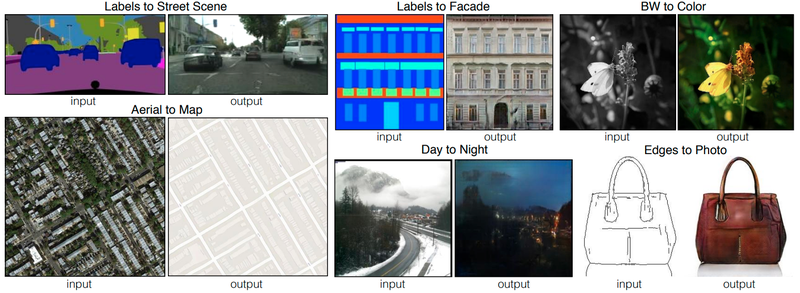
    - 노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용함
    - 다양한 task에 공통적으로 적용할 수 있는 generic approach로 사용가능함. 
    - 손실함수 및 하이퍼 파라미터의 까다로운 조정이 요구되지 않는 다는 장점이 있음

In [3]:
########### 데이터 로드 ##############
path = '/content/drive/MyDrive/COLAB_data/pix2pix/'
train_data_path = '/content/drive/MyDrive/COLAB_data/pix2pix/train/'
val_data_path = '/content/drive/MyDrive/COLAB_data/pix2pix/val/'

In [4]:
print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

number of train examples : 1000
number of validation examples : 5


In [ ]:
########### 샘플이미지 크기 확인 및 시각화 #############
plt.figure(figsize = (20, 15))
for i in range(1,7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)
print(img.shape)

논문에 사용된 그림 처럼 반은 segmentation 이미지, 반은 원본 이미지로 되어있습니다. 
(256, 512, 3)에서 (256,256,3)으로 잘라서 origin, segment로 나눠줍시다


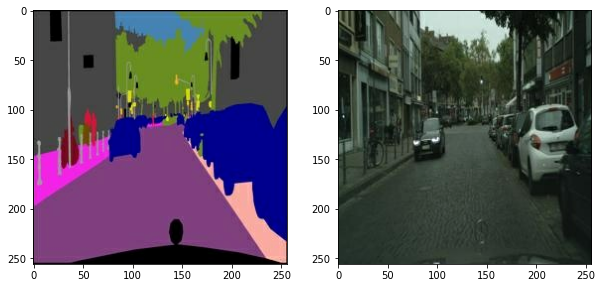

In [6]:
############## 데이터 정규화 및 seg/origin 이미지 로드 함수 ################
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    #segmentation은 오른쪽이니 원본을 반으로 잘라 나눔
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :]
    seg = tf.cast(seg, tf.float32)
    origin = img[:, :w, :]
    origin = tf.cast(origin, tf.float32)
    return normalize(seg), normalize(origin)

############ 데이터 로드 ##############
f = train_data_path + os.listdir(train_data_path)[1]
seg, origin = load_img(f)

########### 시각화 #################
plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(origin))

데이터를 나눴으니 이제 가로 세로 뒤집고 회전시킨  augmentation 데이터를 만들어 줍시다.

In [7]:
############## Augmentation 만들기 ################

 # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
@tf.function()
def apply_augmentation(seg, origin):
    
    #두 이미지를 채널 축으로 연결(3채널*2 -> 6채널)
    stacked = tf.concat([seg, origin], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    #50% 확률로 reflect or constant padding(원래 하던 패딩) 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) #희한하게 패딩값을 1로 준다

    #정해진 사이즈로 랜덤부분 이미지 잘라냄
    out = image.random_crop(padded, size=[256, 256, 6])
    
    #각 50% 확률로 가로 세로 뒤집음
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # 50% 확률로 
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        # 90도 회전시킴
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

print('augmentation 함수 완료')

augmentation 함수 완료


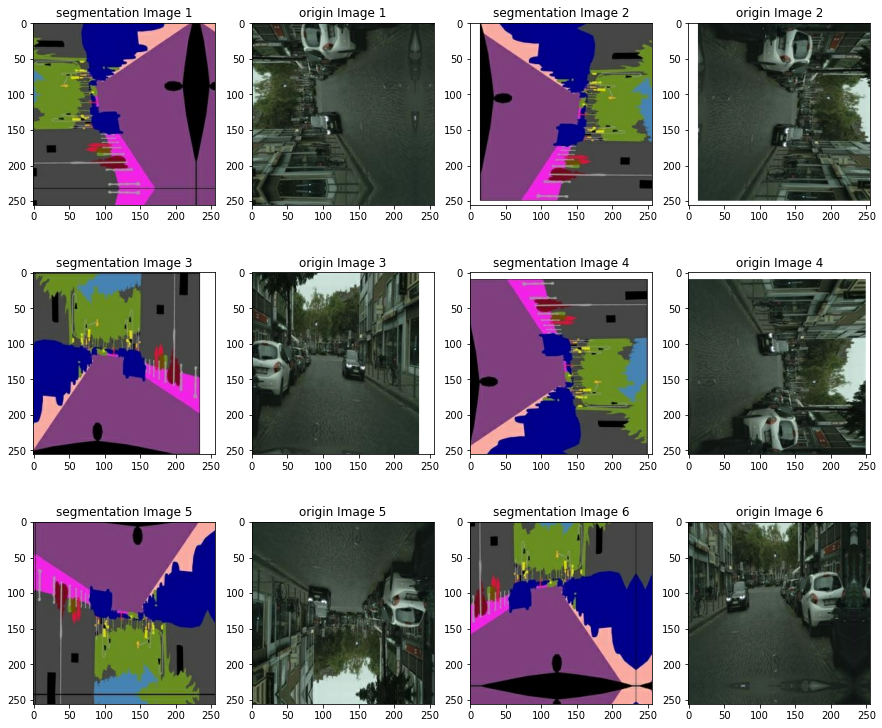

In [8]:
############ 만든 augmentation 시각화 ################
plt.figure(figsize = (15,13))
img_n = 1

for i in range(1,13,2):
    augmented_seg, augmented_origin = apply_augmentation(seg, origin)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"segmentation Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_origin)); plt.title(f"origin Image {img_n}")
    img_n += 1

이미지 하나가 들쑥 날쑥 다양한 augmentation이 만들어졌습니다.   

- **Augmentation** : 학습에 사용하는 데이터가 부족할 때 다양성을 높이기 위해 여러방법으로 생성함. 과적합을 방지하고 일반화 하는 성능을 올려줌.
    - **실제 데이터에서 일어날 수 있는 파라미터로 augmentation을 해야 생성되는 이미지가 좋다**고 함. (생성시 이상하게 될 수 있음)
    - 이후 미니배치를 생성할 때, 이 조건이 랜덤하게 들어감. 즉 에포크마다 데이터셋이 다르게 적용되는 상황임
    - 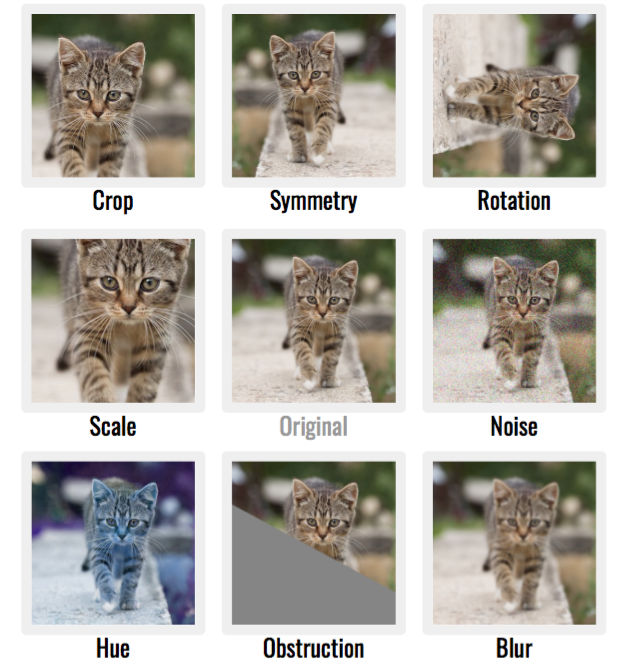   
    다양한 증강의 예

이제 학습데이터에 적용해 다시 시각화 해봅니다.

In [9]:
##################### augmentationtrain data 생성 ###########################
def get_train(img_path):
    #segmentation, origin으로 이미지 잘라서 넣어줌
    seg, origin = load_img(img_path)
    #다양한 모양으로 만들어줌
    seg, origin = apply_augmentation(seg, origin)
    return seg, origin

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

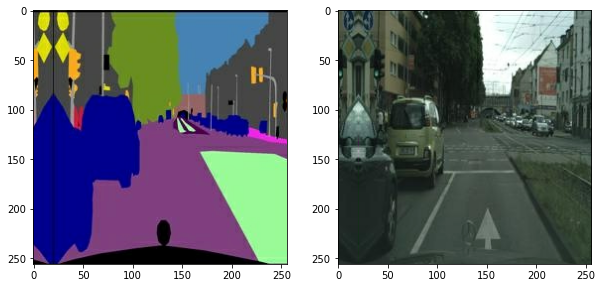

In [10]:
################# augmentation 샘플 이미지 확인 ######################

#train Dataset에서 이미지 1개 받아오기
sample = train_images.take(1)
#numpy 리스트화
sample = list(sample.as_numpy_iterator())

# denormalization
seg, origin = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5
# 시각화
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(origin[0].astype(np.uint8))

이친구는 REFLECT padding이네요. 잘 만들어 진것을 확인했습니다!

## STEP 2. U-Net Generator, Distriminator 구현하여 학습시키기
---
- Generator는 조건인 이미지를 받아 변화된 이미지를 출력함. 여기서 입력이미지와 변화된 이미지는 사이즈가 동일해야함. 
- 보통 Encoder - Decoder 구조를 따른다.
- 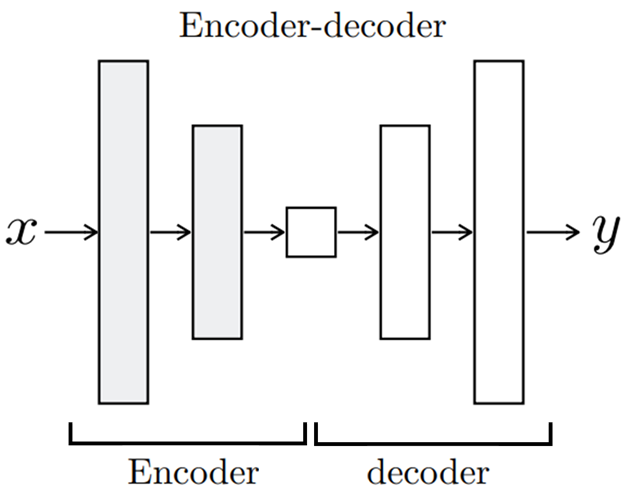
- Encoder : 입력 이미지(x)를 받으면 단계적으로 이미지를 down-sampling 하면서 입력 이미지의 중요한 representation을 학습함
- Decoder : encoder의 output을 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성함
- 상기 과정은 모두 convolution 레이어로 진행되며, 레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 함

- 하지만 이번에 사용되는 **U-net은 각 레이어마다 Encoder와 Decoder가 연결(skip connection)**되어 있음.
- 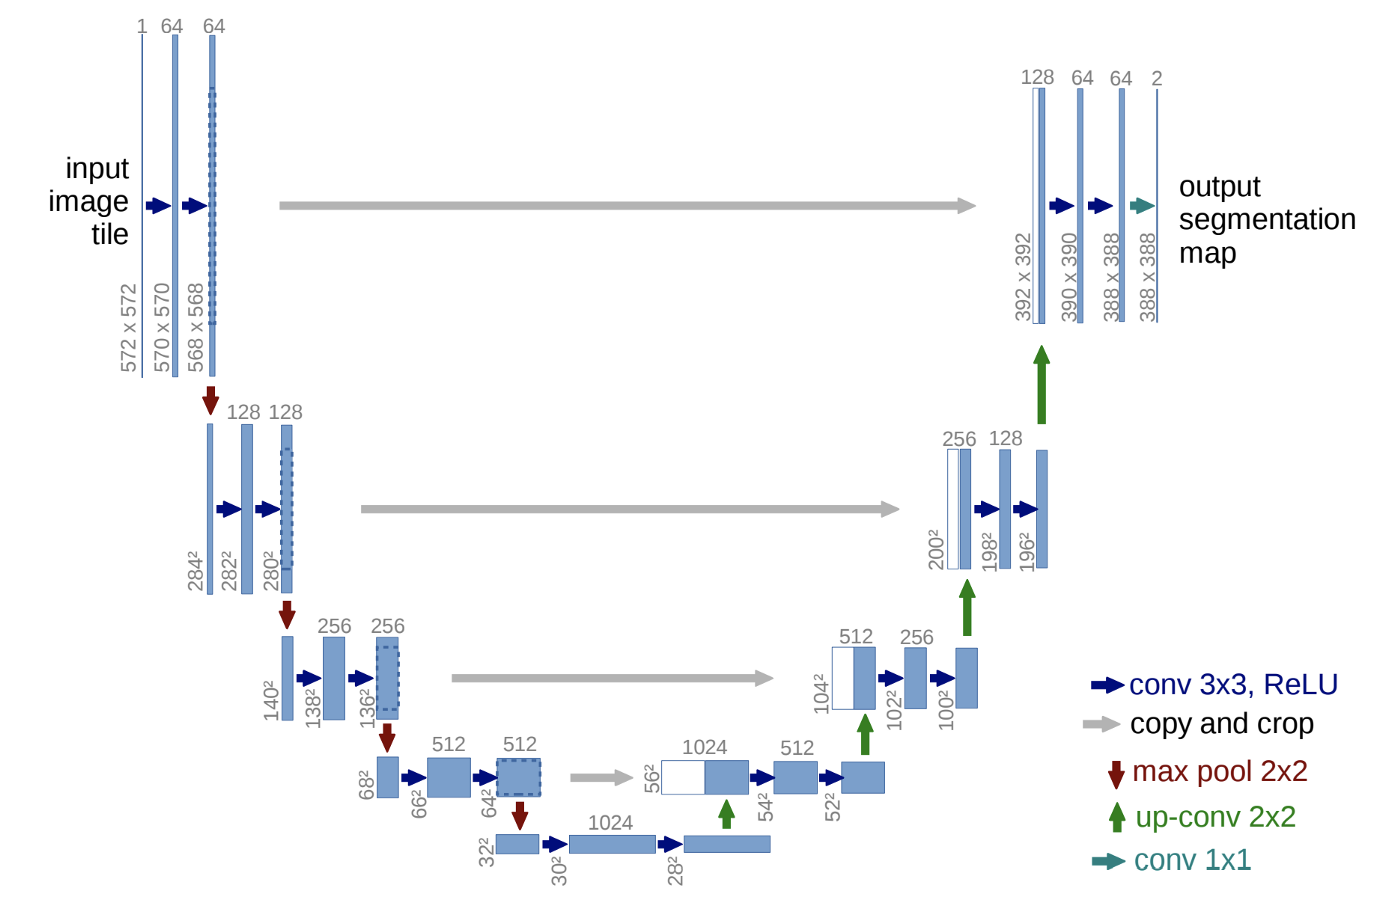
- Decoder가 변환된 이미지를 더 잘 생성하도록 삭제되는 특징들을 보완하기 위해 Encoder로부터 더 많은 추가 정보를 이용하는 방법!
- 얕은 층의 특징맵을 깊은 층의 특징맵과 결합하여 Segmentation이 내제하는 Localization과 Context(Semantic Information) 사이의 트레이드 오프를 해결할 수 있음  
- 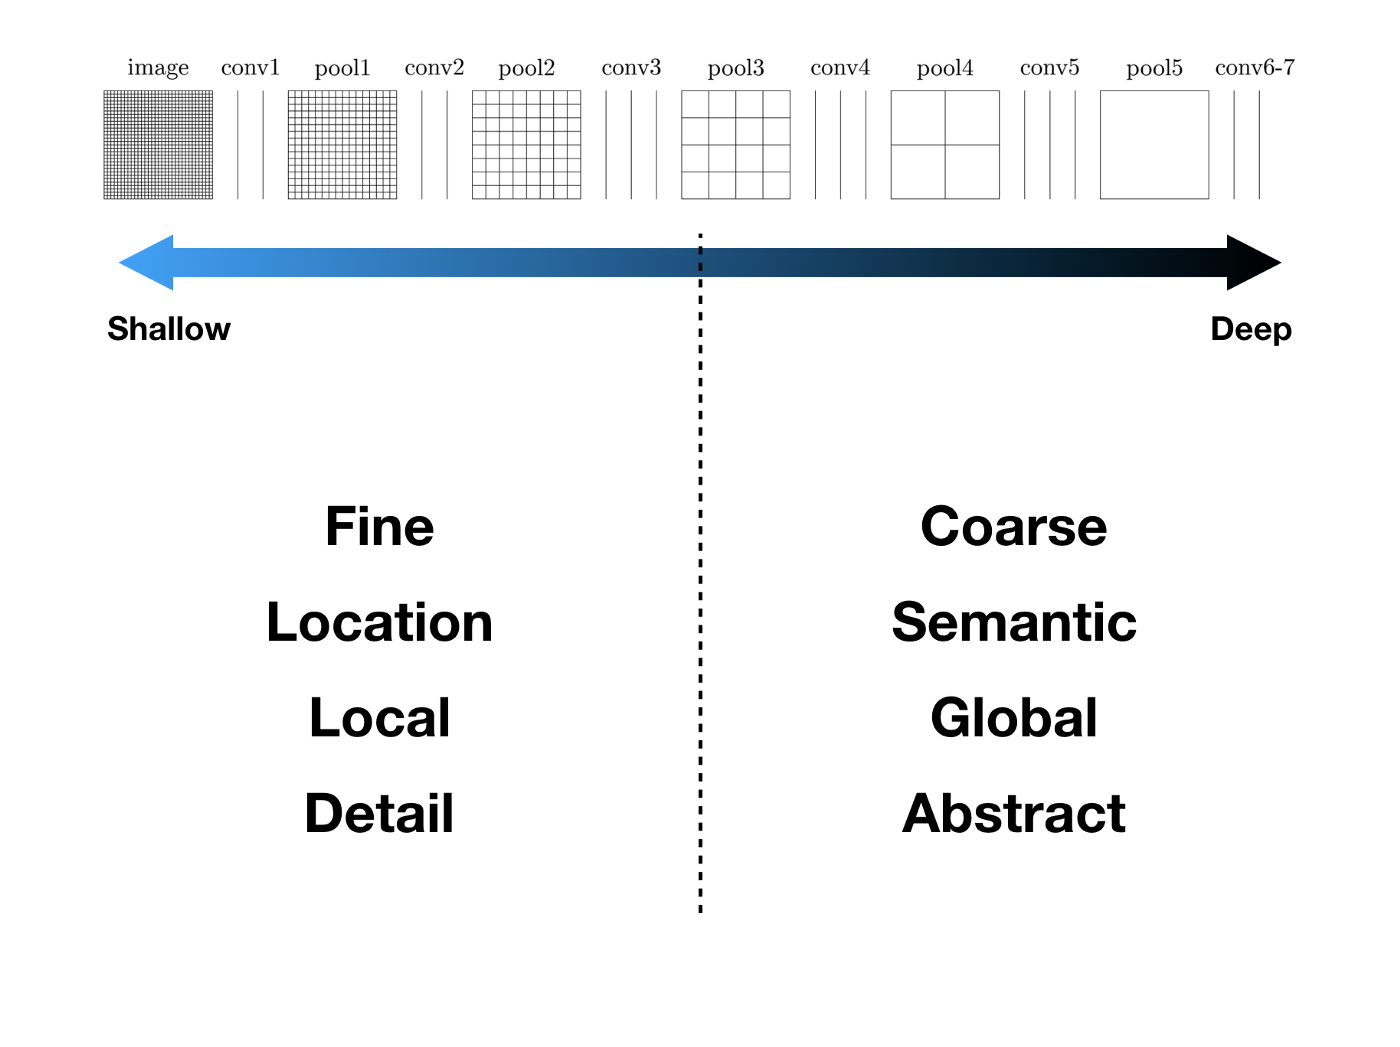
- 이런 U-net구조의 Gnerator를 사용하면 단순 Encoder-Decoder와 비교하여 비교적 선명한 결과를 얻을 수 있음. 
- 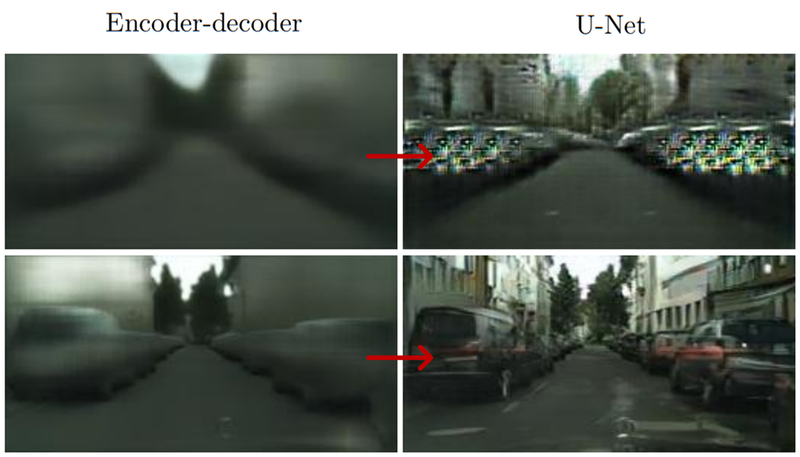
- [U-Net 논문 리뷰](https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a)

### 2-1. Generator 구현
---
- Pix2Pix 논문을 따라 구현해봅니다.  
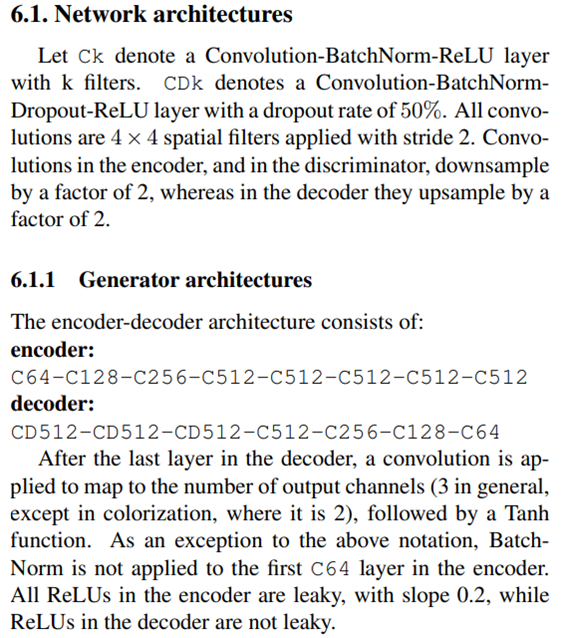  
- pix2pix는 조건 이미지 x를 어떻게 주느냐에 따라 output을 원하는 대로 바꿀 수 있다. 노이즈 z는 출력 이미지가 고정된 이미지만 생성하는 것을 방지하기 위해 사용한다. 그러나 노이즈가 반드시 gaussian noise일 필요가 없어서 dropout의 형태로 G에 포함시켰다. 그래서 아래의 신발 그림에서는 z가 없다.
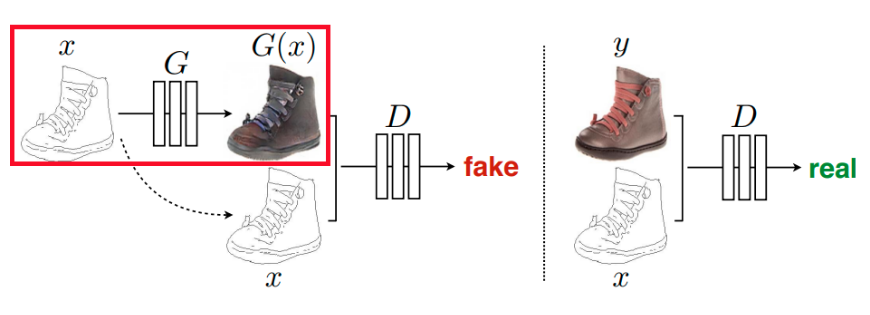

- [참고 블로그](https://velog.io/@guide333/pix2pix)

In [10]:
################# 기초 Encode Block 만들기 #################
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        #batch normalization 유무
        self.use_bn = use_bn
        #논문처럼 conv2D filter (4 *4), stride 2로 구성       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        #batch normalization
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
        

################# 기초 Decode Block 만들기 #################
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        # 논문처럼 Conv2D transpose 구성
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

print('Encode/Decode Block 완룡')

Encode/Decode Block 완룡


In [11]:
############ U-net Gnerator #############

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # 논문처럼 layer 구성함
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            #첫 레이어에선 batch normalization 안함
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        #인코더 끝
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            # 처음 3개 레이어는 dropout 진행
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            # 나머지 레이어는 dropout X
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        #마지막엔 3채널로 맞춰줌
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
        #디코더 끝
        
    def call(self, x):
        #↓U-Net 특징!!!!!!!!!!
        #인코더 특징 담을 리스트 생성
        features = []
        for block in self.encode_blocks:
            x = block(x)
            # 인코더 레이어별 특징 담음
            features.append(x)
        
        #마지막은 어짜피 그대로 넘어가니까 특징에서 뺌
        features = features[:-1]
        ###### 인코더 끝 #########
        
        # features[::-1]로 뒤에서부터 출력시킴
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) #디코더 마지막 채널 뒤에 특징 채널 concat

        # 3채널로 맞춰줄 마지막 conv     
        x = self.last_conv(x)
        return x
        ###### 디코더 끝 #########
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
print('U-net Generator 완료')

U-net Generator 완료


In [12]:
################# 모델 서머리로 구성 확인 ######################
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

bottle neck인 마지막 encode_block_7을 기점으로 디코더가 진행되며, 디코더에서 encode block의 역순으로 feature을 참고하는게 보인다.


### 2-2 Discriminator 구현
---
- Discriminator도 논문에 맞춰 구현해준다.   
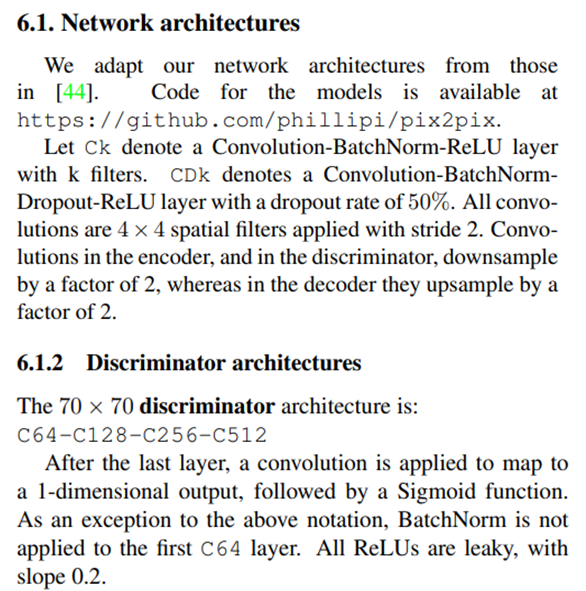


In [13]:
############ Discriminator 기본 Block 구현 ##################
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        #활성함수 사용 유무 나타내줌
        self.act = act
    
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print('Discriminator block 구현 완료')

Discriminator block 구현 완료


이렇게 
- 패딩 통과 유무 `layers.ZeroPadding2D()`
- `Conv2D`의 stride 값, filter size 값으로 출력 사이즈를 조절할 수 있다.

Pix2Pix는 Discriminator가 70x70 PatchGAN을 사용하기 때문에 사이즈를 맞춰주기 위해 위의 블록을 적절하게 써봅니다.

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
    
        self.block1 = layers.Concatenate()
        #처음은 batch normal X
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        # 마지막은 relu X , batch normal X
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        # 마지막 sigmoid
        self.sigmoid = layers.Activation("sigmoid")
        
        # 아까처럼 for문 사용해서 만들땐 이런식으로 
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    # Discriminator엔 x, y 두개 입력 후 비교
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("Discriminator 모델 완료")

Discriminator 모델 완료


In [15]:
########### 모델 구성확인 ###############
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치합니다.
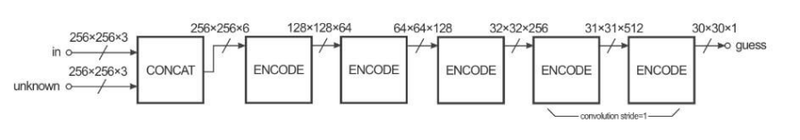

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠습니다.

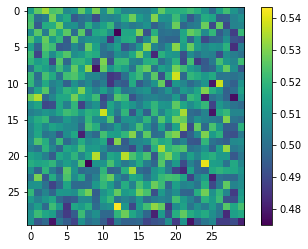

In [17]:
# 임의의 두 input 투입
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- 이렇게 생성된 (30 * 30) 이미지의 각 픽셀 하나가 원본 그림의 (70 * 70) 사이즈를 나타내주는 Patch가 됨  
- 이미지 내 패치 단위로 진짜/가짜 여부를 판별하니, 작은 파라미터로 빠르게 작동한다는 장점이 있음 -> 임의의 큰 이미지에도 적용가능 




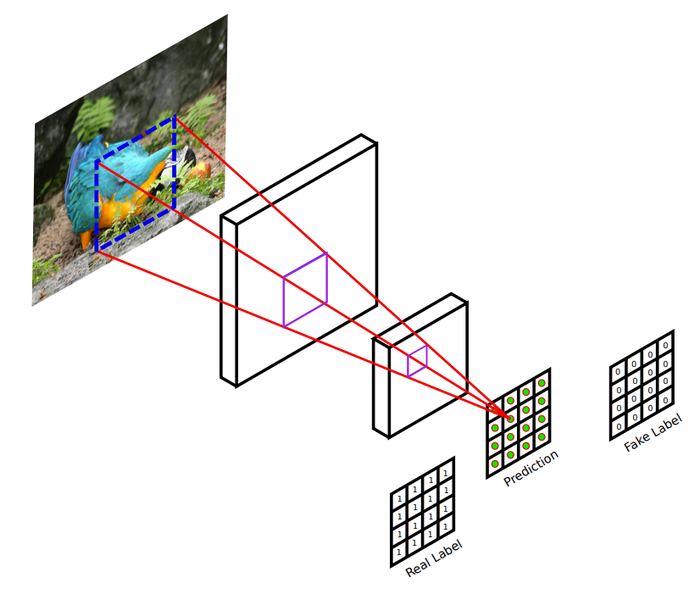

**각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용**함

- patch size별 결과 비교   
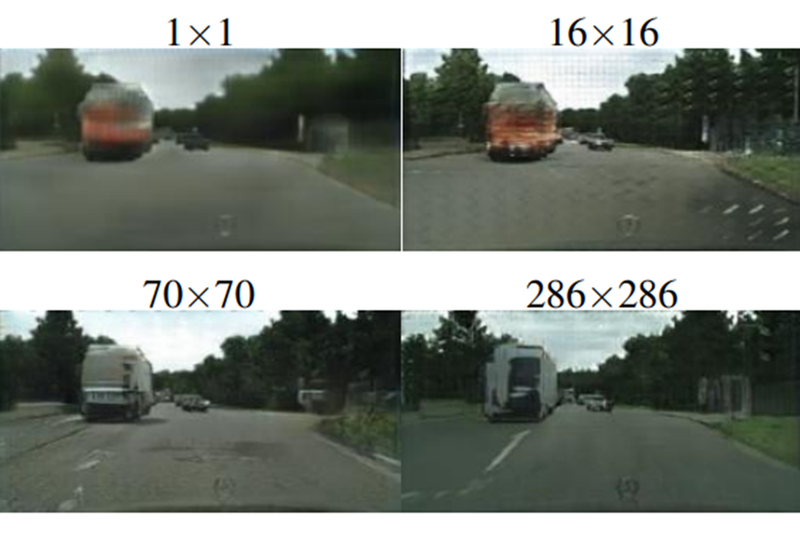

- 마지막에 보이는 286x286이라 적힌 이미지는 DCGAN의 Discriminator와 같이 전체 이미지에 대해 하나의 확률 값을 출력하여 진짜/가짜를 판별하도록 학습한 결과임 (입력 이미지 크기가 286x286) 
- 16x16, 1x1로 갈수록 더 작은 영역을 보고 각각의 확률 값을 계산하므로 Discriminator의 출력값의 개수가 더 많음
-  위 4개의 이미지를 살펴보면, 너무 작은 patch를 사용한 결과(1x1, 16x16)는 품질이 좋지 않으며, 70x70 patch를 이용한 결과가 전체 이미지를 사용한 결과(286x286)보다 조금 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라고 볼 수 있음

Generator와 Discriminator를 만들었으니 이제 모델을 학습시켜 줘볼까요!

## STEP 3. 모델 학습 후, val 이미지 사용하여 Generator 로 생성해보기
---

### 3-1. Loss 구현 및 Optimizer 설정
---
- Pix2Pix의 목적함수   
    1) 기존 cGAN 목적 함수   
$$L_{cGAN}(G,D)=Ex, y[logD(x,y)]+Ex, z[log (1−D(G(x,z)))]$$
    2) D의 할일은 그대로이지만, G는 단지 D를 속이는 것뿐만 아니라 ground truth에도 가깝도록 만들어야 함
$$G^∗=arg minG maxD LcGAN(G,D)+λL_{L1}(G)$$

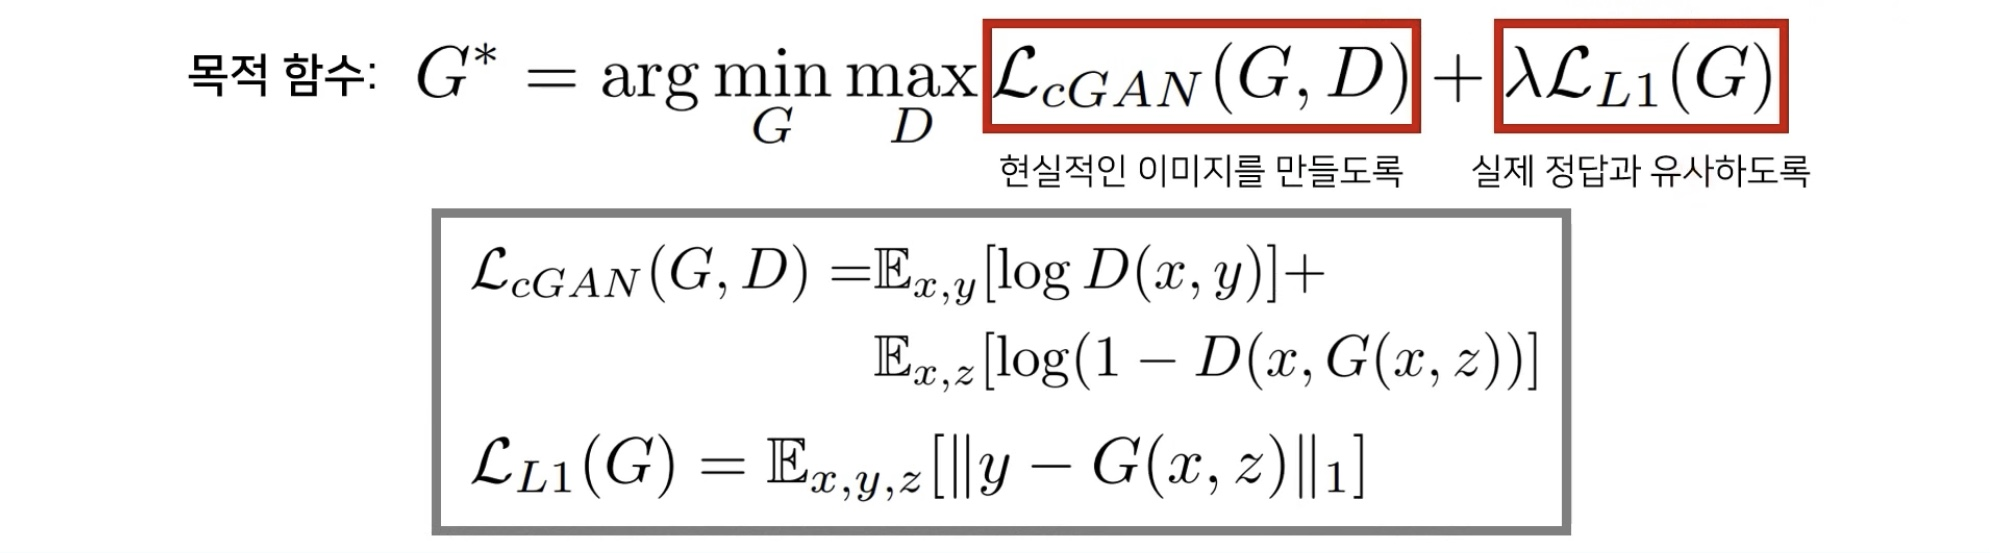


- 참고) L2보다는 L1을 사용하는 것이 덜 흐린 이미지를 생성하는 데 도움이 되었다고 함
- L2 loss는 마지막에 average를 하기때문에 이미지가 blurry해진하는 단점이 있다.   
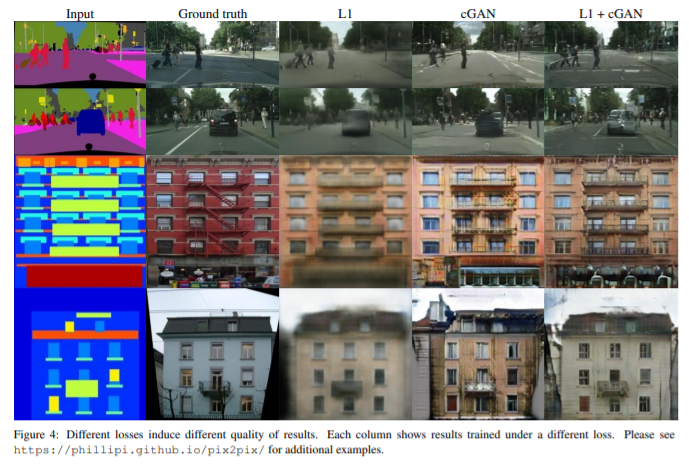


In [16]:
########### loss 구현 ##############
# 원래 CGAN loss용 BCE
bce = losses.BinaryCrossentropy(from_logits = False)
# Pix2Pix L1 loss용 MAE
mae = losses.MeanAbsoluteError()

# generaotr loss
def get_gene_loss(fake_output, real_output, fake_disc):
    # 진짜-가짜 사이의 MAE 비교 -> 원본과 비슷하게 생성하도록 유도
    l1_loss = mae(real_output, fake_output)
    # generaotr fake img가 1(진짜)로 보이게 해야하니까 
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    #fake는 0과 비교, real은 1과 비교해서 loss 
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print('Pix2Pix loss 구현 완료')

Pix2Pix loss 구현 완료


Optimizer은 논문에서 나왔던 것과 동일하게 설정해줍니다.

In [17]:
########## Optimizer 설정 ##############
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

이제 상기 loss와 optimizer를 통해 Generator와 Discriminator를 학습시켜 줍니다.

In [18]:
############# 1회 학습 함수 구현 #################

# 속도 향상을 위한 tf.function사용
@tf.function
def train_step(seg, origin):

    # 가중치값 저장
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator fake 생성
        fake_image = generator(seg, training=True)

        # Discriminator에 Input
            # Fake : 조건 - 생성 이미지 비교 
        fake_disc = discriminator(seg, fake_image, training=True)
            # Real : 조건  오리지널 이미지 비교
        real_disc = discriminator(seg, origin, training=True)

        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_image, origin, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) # L1 손실 반영 λ=100 (ref.Pix2Pix논문)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    # 가중치 저장            
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    #Optimizer 적용
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("학습 함수 완료")

학습 함수 완료


In [34]:
############## 학습 모델 #################
def train(train_images, EPOCHS):
    #시작시간 저장 및 히스토리 생성
    start = time.time()
    # loss 저장용 history   
    history = {'gen_loss':[], 'L1_loss':[], 'disc_loss':[]}

    #에포크돌리기
    for epoch in range(1, EPOCHS+1):
        epoch_start = time.time()

        #배치별 데이터 셋을 입력하고 iterator 
        for i, (seg, origin) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(seg, origin)
            history['gen_loss'].append(g_loss)
            history['L1_loss'].append(l1_loss)
            history['disc_loss'].append(d_loss)

            if i % 50 == 0:
                display.clear_output(wait=True)
                print(f"EPOCH[{epoch}] - iter[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
                
        print('Time for epoch {} : {} sec'.format(epoch, int(time.time()-epoch_start)))

        # epoch 20번에 한번씩 체크포인트 생성
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(epoch, i)
    
    #마지막 결과 표시
    draw_train_history(history, epoch)
    print(f"EPOCH[{epoch}] - iter[{i+1}] \
                \nGenerator_loss:{g_loss.numpy():.4f} \
                \nL1_loss:{l1_loss.numpy():.4f} \
                \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    print('Time for training : {} sec'.format(int(time.time()-start)))
    

In [20]:
############## 학습 loss 기록용 함수 #################
def draw_train_history(history, epoch):
    plt.figure(figsize = (15, 6))

    # Generator loss 
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['L1_loss']) 
    plt.title('Generator loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'L1_loss'], loc='upper left')  
    plt.grid(True)

    # Discriminator loss 
    plt.subplot(212)  
    plt.plot(history['disc_loss'])  
    plt.title('discriminator loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['disc_loss'], loc='upper left')
    plt.grid(True)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)  

    plt.show()

In [30]:
########### 이미지 추출 및 저장 ##############
def generate_and_save_images(epoch, i):

    test_ind = 1

    f = val_data_path + os.listdir(val_data_path)[test_ind]
    seg, origin = load_img(f)

    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(seg))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(origin))
   
    plt.savefig('{}generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(path, epoch, i))

    plt.show()

In [28]:
############## 모델 저장 Check Point 생성 ####################
checkpoint_dir = path + 'training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = gene_opt,
                                 discriminator_optimizer = disc_opt,
                                 generator = generator,
                                 discriminator = discriminator)

In [29]:
############ Epoch 및 Generator, Discriminator 선택 ##########
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

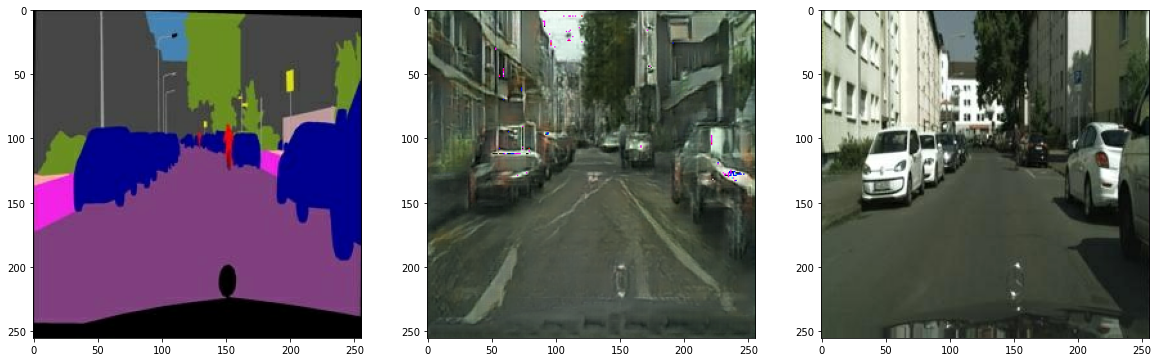

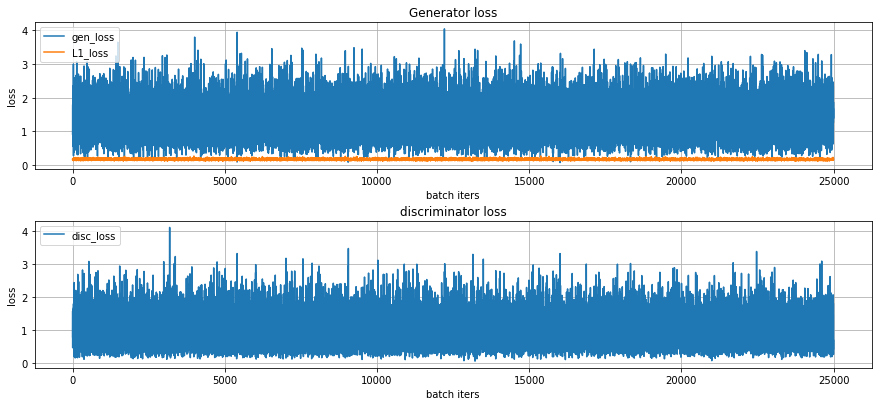

EPOCH[100] - iter[250]                 
Generator_loss:1.6575                 
L1_loss:0.1760                 
Discriminator_loss:1.7836

Time for training : 2442 sec


In [39]:
######## 학습시키기 ################
train_1 = train(train_images, EPOCHS)

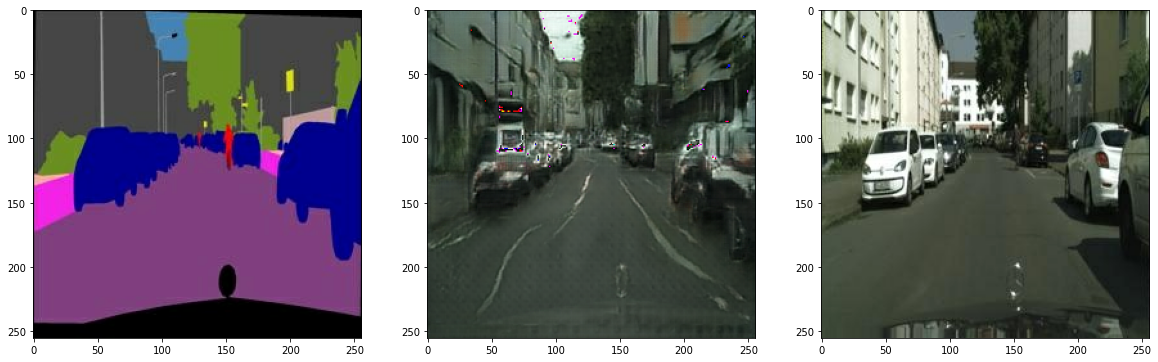

In [38]:
############## Check Point 로드 함수 #################
checkpoint_dir = path + 'training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

############ Check point 확인 #############
test_ind = 1

f = val_data_path + os.listdir(val_data_path)[test_ind]
seg, origin = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(origin))

음 가운데 Generator의 생성 그림을 보니 체크 포인트가 잘 작동하는 것을 알 수 있다!

## STEP 4. Generator 생성 후 결과 나열하기
---
스케치, 생성사진, 실제사진


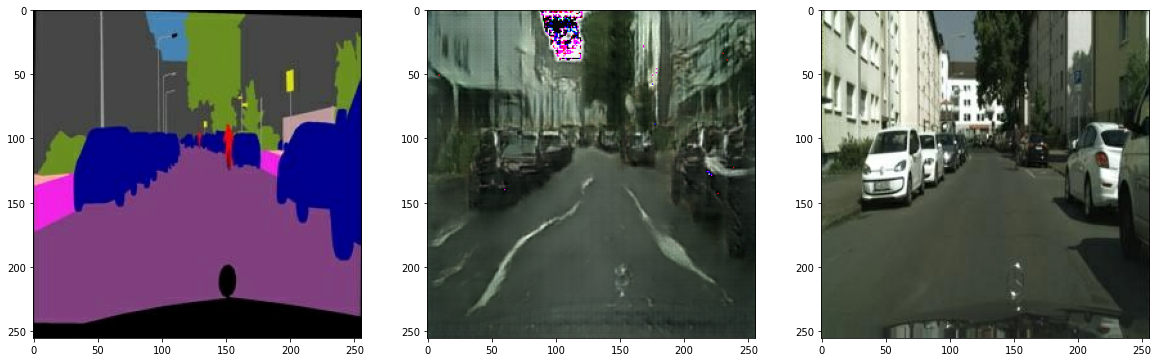

In [33]:
############### 기본 모델 100 epoch ################
test_ind = 1

f = val_data_path + os.listdir(val_data_path)[test_ind]
seg, origin = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(origin))

100 epoch만 돌렸는데도 어느정도 비슷한 구성을 나타내고 있는 것을 알 수 있다.   
100 추가하여 더 비교해보도록 하자!
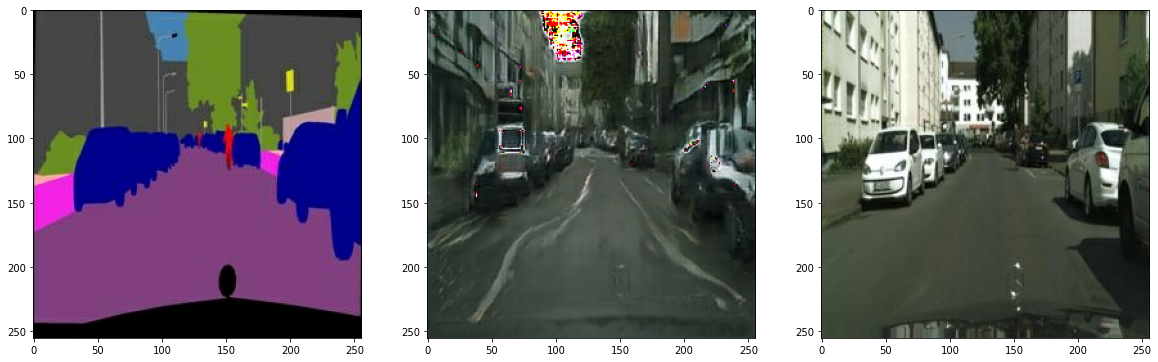

300 epoch   
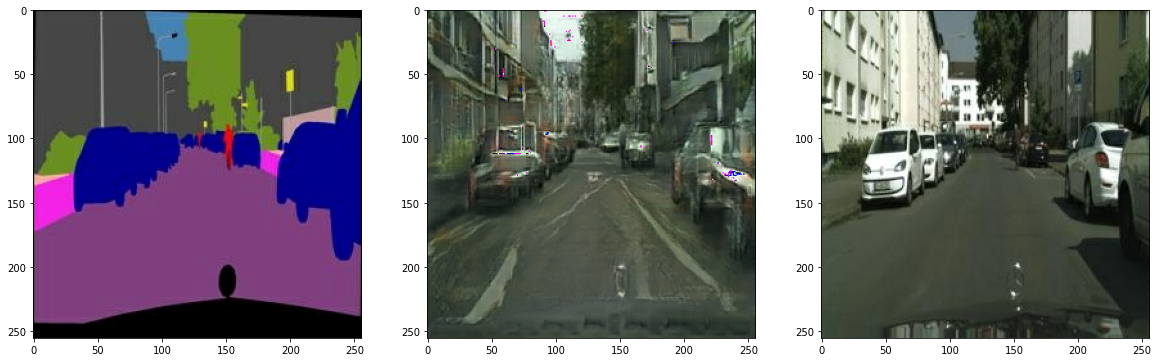

300 epoch시 loss 그래프  
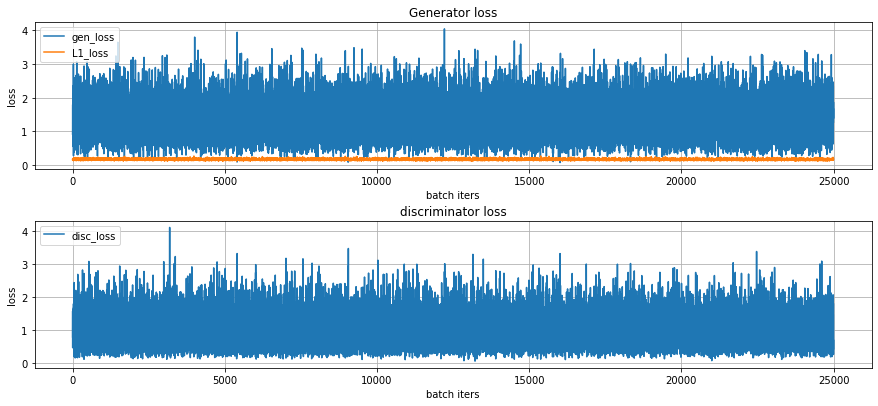

In [40]:
################# 학습 결과 gif 파일화 하기 ############################
anim_file = path + 'pix2pix_test_image_1(200~300).gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(path + '/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

## STEP 5. 추가적인 모델학습 진행하기
---
중간 손실 값에 대한 로그를 남겨

- [Generator, patch gan size 변경](https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb)

- [Patch GAN 설명 및 이미지 사이즈 계산](https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207)

- [텐서플로우 공식 문서 : pix2pix: Image-to-image translation with a conditional GAN](https://www.tensorflow.org/tutorials/generative/pix2pix#%EC%83%9D%EC%84%B1%EA%B8%B0_%EB%B9%8C%EB%93%9C%ED%95%98%EA%B8%B0) -> https://velog.io/@guide333/pix2pix 여기에 제너레이터 모델 바꾼 예시 있음